In [564]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [565]:
# GPU setting

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#print(torch.cuda.get_device_name(0)) #Google colab = TESLA T4

In [566]:
 # Data load

df = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949')

cluster = pd.read_csv('경기도_clustered1.csv',encoding = 'cp949',index_col = 0)
cluster

,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,고양시,...,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시,cluster
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,63.40000,67.80000,77.70000,60.50000,68.10000,53.00000,92.60000,92.60000,66.80000,69.50000,...,92.60000,71.10000,73.00000,82.40000,82.00000,102.80000,93.60000,59.70000,83.20000,1
2013-02-01,63.30000,67.20000,77.40000,60.20000,67.70000,52.90000,92.50000,90.90000,66.60000,69.00000,...,92.80000,70.90000,72.90000,82.00000,81.70000,102.80000,93.60000,59.10000,83.00000,1
2013-03-01,63.20000,66.90000,76.90000,60.00000,67.40000,52.60000,92.40000,90.10000,66.30000,68.60000,...,92.80000,70.80000,72.80000,81.90000,81.40000,102.70000,93.60000,58.70000,82.90000,1
2013-04-01,63.30000,67.10000,76.40000,59.80000,67.40000,52.60000,92.40000,90.00000,66.30000,68.10000,...,93.50000,70.70000,73.20000,82.30000,81.70000,102.70000,93.90000,58.60000,82.90000,1
2013-05-01,63.40000,67.50000,76.40000,59.60000,67.60000,52.90000,92.40000,89.80000,66.60000,68.10000,...,93.80000,71.00000,73.60000,82.30000,81.90000,103.60000,94.70000,58.80000,82.90000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,109.50000,104.80000,107.20000,111.70000,110.20000,107.30000,113.20000,107.70000,110.70000,107.60000,...,114.80000,105.30000,111.60000,107.90000,109.50000,106.60000,108.40000,112.90000,115.90000,0
2021-12-01,109.80000,105.10000,107.40000,112.00000,110.80000,107.40000,114.10000,107.50000,111.20000,108.00000,...,116.10000,105.60000,111.60000,108.40000,109.80000,107.20000,109.00000,113.00000,116.70000,0
2022-01-01,109.80000,105.10000,107.40000,111.80000,110.80000,107.30000,114.30000,107.50000,111.30000,108.10000,...,116.90000,105.60000,111.50000,108.70000,109.80000,107.10000,109.20000,113.00000,116.80000,0


In [567]:
data = pd.read_csv('경기도변수.csv')
feature = pd.read_csv('경기도변수.csv',index_col = 0)
data

,date,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
0,2013-01-01,73.50000,64.75625,93.90000,80.10000,102.86800,92.72800,5.78000,82.68933,76.00764,1089.00000,1841.10000,1961.90000,503.67000,8413721.00000,54632,13631
1,2013-02-01,73.20000,64.42500,93.66667,79.80000,90.00900,93.03800,5.66000,82.87118,76.10804,1083.00000,1857.10000,2026.50000,535.87000,7268443.00000,65640,14925
2,2013-03-01,73.10000,64.22500,93.55000,79.60000,101.38800,92.95200,5.54000,83.16272,76.37669,1111.00000,1862.40000,2004.90000,555.02000,10160177.00000,87563,17718
3,2013-04-01,73.20000,64.30000,93.76667,79.50000,101.29500,92.82300,5.42000,83.55404,76.85819,1101.00000,1867.70000,1964.00000,563.87000,9757932.00000,106498,22790
4,2013-05-01,73.40000,64.49375,94.11667,79.60000,102.31300,92.82300,5.24000,83.79708,77.09053,1129.70000,1870.30000,2001.05000,577.87000,10837979.00000,120393,25910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2021-10-01,103.50000,107.45625,108.65000,108.80000,114.80000,103.35000,3.47000,102.45093,103.90395,1168.60000,3543.40000,2970.68000,992.33000,14689855.00000,119686,29187
106,2021-11-01,104.10000,108.45625,110.16667,109.80000,119.30000,103.87000,3.58000,102.91790,104.54323,1187.90000,3594.70000,2839.01000,965.63000,14483042.00000,111172,26593
107,2021-12-01,104.40000,108.79375,111.03333,110.20000,126.70000,104.04000,3.68000,103.17831,104.79809,1188.80000,3620.10000,2977.65000,1033.98000,19169150.00000,101766,25669
108,2022-01-01,104.40000,108.75000,111.38333,110.30000,115.10000,104.69000,3.75000,103.25089,104.79087,1205.50000,3634.30000,2663.34000,872.87000,13736304.00000,87825,20544


In [568]:
train = data.copy()

In [569]:
train.corr()

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,M2,코스피,코스닥,건축허용면적,거래량 전국,거래량 경기
seoul,1.00000,0.90937,0.22791,0.77387,0.65565,0.98536,-0.78876,0.82194,0.83350,0.51119,0.98395,0.71342,0.80426,0.12069,0.27725,0.46107
Avg_1,0.90937,1.00000,0.43014,0.95232,0.65904,0.91431,-0.73825,0.85927,0.86416,0.45403,0.95073,0.82543,0.85191,0.21349,0.14592,0.22341
Avg_2,0.22791,0.43014,1.00000,0.63663,0.26381,0.31619,-0.26385,0.62986,0.60502,0.12227,0.25843,0.40436,0.41053,0.46749,-0.12229,-0.11360
Avg_3,0.77387,0.95232,0.63663,1.00000,0.61770,0.80261,-0.59546,0.82992,0.82501,0.35248,0.82588,0.83377,0.80558,0.25581,-0.00010,0.04684
MMI,0.65565,0.65904,0.26381,0.61770,1.00000,0.64364,-0.50888,0.59033,0.59217,0.22583,0.66092,0.59047,0.57564,0.37032,0.31797,0.35594
CPI,0.98536,0.91431,0.31619,0.80261,0.64364,1.00000,-0.78866,0.86051,0.86782,0.47790,0.97765,0.73679,0.80020,0.13549,0.25272,0.43478
대출금리,-0.78876,-0.73825,-0.26385,-0.59546,-0.50888,-0.78866,1.00000,-0.88344,-0.89777,-0.55747,-0.82740,-0.57529,-0.73038,-0.41693,-0.54202,-0.61100
전세가격지수 전국,0.82194,0.85927,0.62986,0.82992,0.59033,0.86051,-0.88344,1.00000,0.99877,0.44409,0.85400,0.73851,0.83238,0.45508,0.31973,0.41120
전세가격지수 경기도,0.83350,0.86416,0.60502,0.82501,0.59217,0.86782,-0.89777,0.99877,1.00000,0.46612,0.86609,0.73232,0.83338,0.44888,0.33749,0.42914
환율,0.51119,0.45403,0.12227,0.35248,0.22583,0.47790,-0.55747,0.44409,0.46612,1.00000,0.52514,0.03280,0.22826,0.16604,0.12524,0.22564


In [570]:
# Training/Test ratio = 7:3

Train_ratio = 0.7

Test_ratio = 0.3

In [571]:
result =  pd.DataFrame(data=[0,0,0,0],
                             index = ['MAE','RMSE','MAPE', 'R2'],
                             columns=['test'])
predict =  pd.DataFrame(data=[0*14])

lag 변수 생성

In [572]:
df.set_index('date', inplace=True)
data.set_index('date', inplace=True)

In [573]:
lag_col= list(df.columns)


lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
        
df.dropna(inplace=True)

In [574]:
df = df.iloc[:-3,:]
df

,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,고양시,...,포천시_lag3,의왕시_lag1,의왕시_lag2,의왕시_lag3,오산시_lag1,오산시_lag2,오산시_lag3,cluster_lag1,cluster_lag2,cluster_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,63.30000,67.10000,76.40000,59.80000,67.40000,52.60000,92.40000,90.00000,66.30000,68.10000,...,93.60000,58.70000,59.10000,59.70000,82.90000,83.00000,83.20000,1.00000,1.00000,1.00000
2013-05-01,63.40000,67.50000,76.40000,59.60000,67.60000,52.90000,92.40000,89.80000,66.60000,68.10000,...,93.60000,58.60000,58.70000,59.10000,82.90000,82.90000,83.00000,1.00000,1.00000,1.00000
2013-06-01,63.50000,67.90000,76.20000,59.50000,67.60000,53.00000,92.60000,89.60000,66.80000,68.00000,...,93.60000,58.80000,58.60000,58.70000,82.90000,82.90000,82.90000,1.00000,1.00000,1.00000
2013-07-01,63.40000,67.70000,75.50000,59.50000,67.50000,53.10000,92.50000,89.30000,66.70000,67.90000,...,93.90000,59.10000,58.80000,58.60000,82.40000,82.90000,82.90000,1.00000,1.00000,1.00000
2013-08-01,63.20000,67.40000,75.20000,59.40000,67.20000,52.90000,92.30000,89.00000,66.50000,67.90000,...,94.70000,58.70000,59.10000,58.80000,82.10000,82.40000,82.90000,1.00000,1.00000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,104.70000,102.60000,103.80000,106.20000,104.50000,104.00000,106.20000,104.50000,105.00000,103.10000,...,97.90000,103.10000,100.00000,96.30000,103.50000,100.00000,96.00000,0.00000,0.00000,0.00000
2021-09-01,106.50000,103.60000,105.20000,108.30000,106.70000,105.50000,108.80000,106.40000,107.10000,105.00000,...,100.00000,106.40000,103.10000,100.00000,107.30000,103.50000,100.00000,0.00000,0.00000,0.00000
2021-10-01,108.40000,104.30000,106.50000,110.50000,108.70000,106.70000,111.70000,107.30000,109.30000,106.70000,...,101.60000,109.10000,106.40000,103.10000,110.70000,107.30000,103.50000,0.00000,0.00000,0.00000


In [575]:
lag_col= list(data.columns)


lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        data['{0}_lag{1}'.format(col,i+1)] = data['{}'.format(col)].shift(i+1)
        
data.dropna(inplace=True)

In [576]:
data= data.iloc[:-2,:]
data

,seoul,Avg_1,Avg_2,Avg_3,MMI,CPI,대출금리,전세가격지수 전국,전세가격지수 경기도,환율,...,코스닥_lag3,건축허용면적_lag1,건축허용면적_lag2,건축허용면적_lag3,거래량 전국_lag1,거래량 전국_lag2,거래량 전국_lag3,거래량 경기_lag1,거래량 경기_lag2,거래량 경기_lag3
date,,,,,,,,,,,,,,,,,,,,,
2013-04-01,73.20000,64.30000,93.76667,79.50000,101.29500,92.82300,5.42000,83.55404,76.85819,1101.00000,...,503.67000,10160177.00000,7268443.00000,8413721.00000,87563.00000,65640.00000,54632.00000,17718.00000,14925.00000,13631.00000
2013-05-01,73.40000,64.49375,94.11667,79.60000,102.31300,92.82300,5.24000,83.79708,77.09053,1129.70000,...,535.87000,9757932.00000,10160177.00000,7268443.00000,106498.00000,87563.00000,65640.00000,22790.00000,17718.00000,14925.00000
2013-06-01,73.20000,64.55000,94.30000,79.50000,99.72200,92.71000,5.05000,83.97808,77.26569,1142.00000,...,555.02000,10837979.00000,9757932.00000,10160177.00000,120393.00000,106498.00000,87563.00000,25910.00000,22790.00000,17718.00000
2013-07-01,72.80000,64.36875,94.23333,79.10000,99.90700,92.90900,5.09000,84.23058,77.47430,1123.50000,...,563.87000,10007009.00000,10837979.00000,9757932.00000,160468.00000,120393.00000,106498.00000,33741.00000,25910.00000,22790.00000
2013-08-01,72.50000,64.17500,94.08333,78.80000,96.11500,93.23800,5.06000,84.58286,77.93904,1110.00000,...,577.87000,11233555.00000,10007009.00000,10837979.00000,74944.00000,160468.00000,120393.00000,16437.00000,33741.00000,25910.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,101.70000,104.06250,104.50000,104.70000,110.50000,102.75000,3.32000,101.22584,101.99146,1159.50000,...,981.78000,14591577.00000,16013705.00000,13891755.00000,140102.00000,144759.00000,154949.00000,39146.00000,38191.00000,42027.00000
2021-09-01,102.70000,105.82500,106.61667,106.90000,111.10000,103.17000,3.40000,101.82469,102.96483,1184.00000,...,1029.96000,13946424.00000,14591577.00000,16013705.00000,133495.00000,140102.00000,144759.00000,36154.00000,39146.00000,38191.00000
2021-10-01,103.50000,107.45625,108.65000,108.80000,114.80000,103.35000,3.47000,102.45093,103.90395,1168.60000,...,1031.14000,14652194.00000,13946424.00000,14591577.00000,122333.00000,133495.00000,140102.00000,33662.00000,36154.00000,39146.00000


In [577]:
for i in range(28):
    clust_n = int(cluster[cluster.columns[i]][-1])
    
    answer = []
    for num in range(11):
        if abs(train.corr()['Avg_{}'.format(clust_n+1)][num])>=0.7:
            answer.append(num)
    
    col =[]
    for j in  answer:
        col.append(data.columns[j])
    
    
    x = data[col].replace(',','')
    y = df.iloc[:,i:i+1]
    
       
    train_x = x.iloc[0:int(len(x)*Train_ratio),:]

    train_y = y.iloc[0:int(len(x)*Train_ratio),:]

    test_x = x.iloc[int(len(x)*Train_ratio):,:]

    test_y = y.iloc[int(len(x)*Train_ratio):,:]
    

    
    

    # Normalizing , 둘다 학습하여 성능비교할것

    minmax = MinMaxScaler()

    standard = StandardScaler()

    
    yscaler = minmax.fit(y.values.reshape(-1,1))
    train_x = minmax.fit_transform(train_x)

    train_y = minmax.fit_transform(train_y)

    test_x = minmax.fit_transform(test_x)

    test_y = minmax.fit_transform(test_y)





    # Numpy array상태로는 학습이 불가능하므로, Torch Variable 형태로 변경(data/grad/grad_fn)

    train_x_tensor = Variable(torch.Tensor(train_x))

    train_y_tensor = Variable(torch.Tensor(train_y))

    

    test_x_tensor = Variable(torch.Tensor(test_x))

    test_y_tensor = Variable(torch.Tensor(test_y))

    

    train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0], 1, train_x_tensor.shape[1]))

    train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0], 1, train_y_tensor.shape[1]))

    test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0], 1, test_x_tensor.shape[1]))

    test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0], 1, test_y_tensor.shape[1]) )

    


    ## LSTM network modeling

    class LSTM_Jun(nn.Module):

        def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) : 

            super(LSTM_Jun, self).__init__()

            self.num_classes = num_classes

            self.num_layers = num_layers

            self.input_size = input_size

            self.hidden_size = hidden_size

            self.seq_length = seq_length

            self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

            self.layer_1 = nn.Linear(hidden_size, 256)

            self.layer_2 = nn.Linear(256,256)

            self.layer_3 = nn.Linear(256,128)

            self.layer_out = nn.Linear(128, num_classes)

            self.relu = nn.ReLU() #Activation Func



        def forward(self,x):

            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Hidden State

            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #Internal Process States



            output, (hn, cn) = self.lstm(x, (h_0, c_0))



            hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network

            out = self.relu(hn) #pre-processing for first layer

            out = self.layer_1(out) # first layer

            out = self.relu(out) # activation func relu

            out = self.layer_2(out)

            out = self.relu(out)

            out = self.layer_3(out)

            out = self.relu(out)

            out = self.layer_out(out) #Output layer

            return out

 

    # Code Main

    num_epochs = 20000
    learning_rate = 0.005

    input_size = int(len(x.columns))

    hidden_size = 2 # number of features in hidden state

    num_layers = 1

    num_classes = int(len(y.columns))



    LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, train_x_tensor_final.shape[1]).to(device)



    loss_function = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(LSTM_Jun.parameters(), lr = learning_rate)

 

    for epoch in range(num_epochs) : 

        outputs = LSTM_Jun.forward(train_x_tensor_final.to(device))

        optimizer.zero_grad()

        loss = loss_function(outputs, train_y_tensor.to(device))

        loss.backward()

        optimizer.step() # improve from loss = back propagation

        if epoch % 100 == 0 :

            print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))
            

    # Estimated Value

    test_predict = LSTM_Jun(test_x_tensor_final.to(device)) #Forward Pass

    predict_data = test_predict.data.detach().cpu().numpy() #numpy conversion

    predict_data = minmax.inverse_transform(predict_data) #inverse normalization(Min/Max)
    
    y_pred = predict_data[:,0]

    # Real Value

    real_data = test_y_tensor.data.numpy() # Real value

    real_data = minmax.inverse_transform(real_data) #inverse normalization 
    
    y_test = real_data[:,0]

    
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    MAPE= np.mean(np.abs((y_test - y_pred) / y_test))
    pd.options.display.float_format = '{:.5f}'.format
    
    label = df.columns[i]
    Result = pd.DataFrame(data=[MAE,RMSE, MAPE,R2],
                         index = ['MAE','RMSE','MAPE','R2'],
                         columns=[label])
        
    

    result = pd.concat([result,Result],axis = 1)

    DAYS_TO_PREDICT = 14
    with torch.no_grad():
        test_seq = test_x_tensor_final[:-1]
        preds = []
        for i in range(DAYS_TO_PREDICT):
            y_test_pred = LSTM_Jun(test_seq)[-1:,0]
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(test_x_tensor_final[:-1].shape[0],1,test_x_tensor_final[:-1].shape[2]).float()

    # Prediction value 스케일링 역변환
    pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))
    pred_values

    # 예측값 반올림
    import math

    pred_values_ceiled = list(pred_values.flatten())
    predicted_cases=pred_values_ceiled
    predicted_cases

    predicted_index = pd.date_range(
      start=data.index[-1],
      periods=DAYS_TO_PREDICT + 1, freq = 'MS',
      closed='right'
    )

    predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

    predicted_cases_i = pd.DataFrame(
      data=predicted_cases,
      index=predicted_index
    )
    
    if not i :
        predict = predicted_cases_i
    else:
        predict =pd.concat([predict,predicted_cases_i],axis = 1)

    preds_i = pd.DataFrame(predicted_cases_i)
    feature.index = pd.to_datetime(feature.index)

    y_i = pd.DataFrame(data =df[df.columns[i]].values,index = df.index)
    y_i.index.name = ''


Epoch : 0, loss : 0.38183
Epoch : 100, loss : 0.00067
Epoch : 200, loss : 0.00045
Epoch : 300, loss : 0.00038
Epoch : 400, loss : 0.00032
Epoch : 500, loss : 0.00027
Epoch : 600, loss : 0.00026
Epoch : 700, loss : 0.00022
Epoch : 800, loss : 0.00016
Epoch : 900, loss : 0.00028
Epoch : 1000, loss : 0.00013
Epoch : 1100, loss : 0.00013
Epoch : 1200, loss : 0.00010
Epoch : 1300, loss : 0.00011
Epoch : 1400, loss : 0.00015
Epoch : 1500, loss : 0.00009
Epoch : 1600, loss : 0.00008
Epoch : 1700, loss : 0.00007
Epoch : 1800, loss : 0.00008
Epoch : 1900, loss : 0.00014
Epoch : 2000, loss : 0.00037
Epoch : 2100, loss : 0.00011
Epoch : 2200, loss : 0.00006
Epoch : 2300, loss : 0.00009
Epoch : 2400, loss : 0.00023
Epoch : 2500, loss : 0.00012
Epoch : 2600, loss : 0.00034
Epoch : 2700, loss : 0.00005
Epoch : 2800, loss : 0.00007
Epoch : 2900, loss : 0.00037
Epoch : 3000, loss : 0.00008
Epoch : 3100, loss : 0.00004
Epoch : 3200, loss : 0.00004
Epoch : 3300, loss : 0.00004
Epoch : 3400, loss : 0.000

Epoch : 8000, loss : 0.00030
Epoch : 8100, loss : 0.00030
Epoch : 8200, loss : 0.00031
Epoch : 8300, loss : 0.00031
Epoch : 8400, loss : 0.00033
Epoch : 8500, loss : 0.00031
Epoch : 8600, loss : 0.00030
Epoch : 8700, loss : 0.00030
Epoch : 8800, loss : 0.00029
Epoch : 8900, loss : 0.00029
Epoch : 9000, loss : 0.00029
Epoch : 9100, loss : 0.00029
Epoch : 9200, loss : 0.00031
Epoch : 9300, loss : 0.00029
Epoch : 9400, loss : 0.00029
Epoch : 9500, loss : 0.00032
Epoch : 9600, loss : 0.00029
Epoch : 9700, loss : 0.00029
Epoch : 9800, loss : 0.00029
Epoch : 9900, loss : 0.00029
Epoch : 10000, loss : 0.00029
Epoch : 10100, loss : 0.00029
Epoch : 10200, loss : 0.00029
Epoch : 10300, loss : 0.00030
Epoch : 10400, loss : 0.00033
Epoch : 10500, loss : 0.00029
Epoch : 10600, loss : 0.00030
Epoch : 10700, loss : 0.00029
Epoch : 10800, loss : 0.00030
Epoch : 10900, loss : 0.00029
Epoch : 11000, loss : 0.00036
Epoch : 11100, loss : 0.00029
Epoch : 11200, loss : 0.00029
Epoch : 11300, loss : 0.00032


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.57837
Epoch : 100, loss : 0.00144
Epoch : 200, loss : 0.00108
Epoch : 300, loss : 0.00077
Epoch : 400, loss : 0.00033
Epoch : 500, loss : 0.00025
Epoch : 600, loss : 0.00021
Epoch : 700, loss : 0.00018
Epoch : 800, loss : 0.00014
Epoch : 900, loss : 0.00019
Epoch : 1000, loss : 0.00016
Epoch : 1100, loss : 0.00009
Epoch : 1200, loss : 0.00008
Epoch : 1300, loss : 0.00007
Epoch : 1400, loss : 0.00007
Epoch : 1500, loss : 0.00009
Epoch : 1600, loss : 0.00013
Epoch : 1700, loss : 0.00022
Epoch : 1800, loss : 0.00004
Epoch : 1900, loss : 0.00028
Epoch : 2000, loss : 0.00003
Epoch : 2100, loss : 0.00012
Epoch : 2200, loss : 0.00007
Epoch : 2300, loss : 0.00007
Epoch : 2400, loss : 0.00004
Epoch : 2500, loss : 0.00004
Epoch : 2600, loss : 0.00006
Epoch : 2700, loss : 0.00003
Epoch : 2800, loss : 0.00003
Epoch : 2900, loss : 0.00005
Epoch : 3000, loss : 0.00004
Epoch : 3100, loss : 0.00003
Epoch : 3200, loss : 0.00003
Epoch : 3300, loss : 0.00003
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.38377
Epoch : 100, loss : 0.00036
Epoch : 200, loss : 0.00030
Epoch : 300, loss : 0.00026
Epoch : 400, loss : 0.00022
Epoch : 500, loss : 0.00018
Epoch : 600, loss : 0.00016
Epoch : 700, loss : 0.00014
Epoch : 800, loss : 0.00014
Epoch : 900, loss : 0.00011
Epoch : 1000, loss : 0.00012
Epoch : 1100, loss : 0.00016
Epoch : 1200, loss : 0.00010
Epoch : 1300, loss : 0.00010
Epoch : 1400, loss : 0.00009
Epoch : 1500, loss : 0.00009
Epoch : 1600, loss : 0.00009
Epoch : 1700, loss : 0.00009
Epoch : 1800, loss : 0.00011
Epoch : 1900, loss : 0.00070
Epoch : 2000, loss : 0.00009
Epoch : 2100, loss : 0.00027
Epoch : 2200, loss : 0.00010
Epoch : 2300, loss : 0.00013
Epoch : 2400, loss : 0.00008
Epoch : 2500, loss : 0.00010
Epoch : 2600, loss : 0.00008
Epoch : 2700, loss : 0.00007
Epoch : 2800, loss : 0.00007
Epoch : 2900, loss : 0.00020
Epoch : 3000, loss : 0.00011
Epoch : 3100, loss : 0.00011
Epoch : 3200, loss : 0.00058
Epoch : 3300, loss : 0.00007
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.40303
Epoch : 100, loss : 0.00488
Epoch : 200, loss : 0.00180
Epoch : 300, loss : 0.00115
Epoch : 400, loss : 0.00094
Epoch : 500, loss : 0.00069
Epoch : 600, loss : 0.00051
Epoch : 700, loss : 0.00063
Epoch : 800, loss : 0.00050
Epoch : 900, loss : 0.00017
Epoch : 1000, loss : 0.00018
Epoch : 1100, loss : 0.00023
Epoch : 1200, loss : 0.00014
Epoch : 1300, loss : 0.00012
Epoch : 1400, loss : 0.00013
Epoch : 1500, loss : 0.00012
Epoch : 1600, loss : 0.00010
Epoch : 1700, loss : 0.00045
Epoch : 1800, loss : 0.00010
Epoch : 1900, loss : 0.00011
Epoch : 2000, loss : 0.00010
Epoch : 2100, loss : 0.00014
Epoch : 2200, loss : 0.00009
Epoch : 2300, loss : 0.00010
Epoch : 2400, loss : 0.00011
Epoch : 2500, loss : 0.00009
Epoch : 2600, loss : 0.00015
Epoch : 2700, loss : 0.00008
Epoch : 2800, loss : 0.00008
Epoch : 2900, loss : 0.00039
Epoch : 3000, loss : 0.00008
Epoch : 3100, loss : 0.00014
Epoch : 3200, loss : 0.00007
Epoch : 3300, loss : 0.00007
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.25219
Epoch : 100, loss : 0.00225
Epoch : 200, loss : 0.00136
Epoch : 300, loss : 0.00098
Epoch : 400, loss : 0.00083
Epoch : 500, loss : 0.00071
Epoch : 600, loss : 0.00060
Epoch : 700, loss : 0.00040
Epoch : 800, loss : 0.00032
Epoch : 900, loss : 0.00049
Epoch : 1000, loss : 0.00006
Epoch : 1100, loss : 0.00007
Epoch : 1200, loss : 0.00006
Epoch : 1300, loss : 0.00029
Epoch : 1400, loss : 0.00003
Epoch : 1500, loss : 0.00004
Epoch : 1600, loss : 0.00010
Epoch : 1700, loss : 0.00005
Epoch : 1800, loss : 0.00005
Epoch : 1900, loss : 0.00016
Epoch : 2000, loss : 0.00006
Epoch : 2100, loss : 0.00003
Epoch : 2200, loss : 0.00003
Epoch : 2300, loss : 0.00004
Epoch : 2400, loss : 0.00004
Epoch : 2500, loss : 0.00004
Epoch : 2600, loss : 0.00002
Epoch : 2700, loss : 0.00002
Epoch : 2800, loss : 0.00004
Epoch : 2900, loss : 0.00035
Epoch : 3000, loss : 0.00004
Epoch : 3100, loss : 0.00003
Epoch : 3200, loss : 0.00003
Epoch : 3300, loss : 0.00003
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.61558
Epoch : 100, loss : 0.01774
Epoch : 200, loss : 0.01725
Epoch : 300, loss : 0.01734
Epoch : 400, loss : 0.01703
Epoch : 500, loss : 0.01720
Epoch : 600, loss : 0.01712
Epoch : 700, loss : 0.01710
Epoch : 800, loss : 0.01710
Epoch : 900, loss : 0.01709
Epoch : 1000, loss : 0.01709
Epoch : 1100, loss : 0.01708
Epoch : 1200, loss : 0.01708
Epoch : 1300, loss : 0.01708
Epoch : 1400, loss : 0.01709
Epoch : 1500, loss : 0.01715
Epoch : 1600, loss : 0.01711
Epoch : 1700, loss : 0.01713
Epoch : 1800, loss : 0.01709
Epoch : 1900, loss : 0.01724
Epoch : 2000, loss : 0.01713
Epoch : 2100, loss : 0.01714
Epoch : 2200, loss : 0.01707
Epoch : 2300, loss : 0.01704
Epoch : 2400, loss : 0.01702
Epoch : 2500, loss : 0.01697
Epoch : 2600, loss : 0.01700
Epoch : 2700, loss : 0.01699
Epoch : 2800, loss : 0.01707
Epoch : 2900, loss : 0.01716
Epoch : 3000, loss : 0.01697
Epoch : 3100, loss : 0.01711
Epoch : 3200, loss : 0.01693
Epoch : 3300, loss : 0.01701
Epoch : 3400, loss : 0.016

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.41147
Epoch : 100, loss : 0.05897
Epoch : 200, loss : 0.05230
Epoch : 300, loss : 0.05213
Epoch : 400, loss : 0.05291
Epoch : 500, loss : 0.05441
Epoch : 600, loss : 0.05164
Epoch : 700, loss : 0.05140
Epoch : 800, loss : 0.05232
Epoch : 900, loss : 0.05147
Epoch : 1000, loss : 0.05319
Epoch : 1100, loss : 0.05138
Epoch : 1200, loss : 0.05127
Epoch : 1300, loss : 0.05096
Epoch : 1400, loss : 0.05146
Epoch : 1500, loss : 0.05172
Epoch : 1600, loss : 0.05066
Epoch : 1700, loss : 0.05057
Epoch : 1800, loss : 0.05158
Epoch : 1900, loss : 0.05097
Epoch : 2000, loss : 0.04961
Epoch : 2100, loss : 0.04931
Epoch : 2200, loss : 0.04960
Epoch : 2300, loss : 0.04890
Epoch : 2400, loss : 0.04870
Epoch : 2500, loss : 0.04866
Epoch : 2600, loss : 0.04977
Epoch : 2700, loss : 0.05019
Epoch : 2800, loss : 0.04909
Epoch : 2900, loss : 0.04798
Epoch : 3000, loss : 0.04858
Epoch : 3100, loss : 0.04736
Epoch : 3200, loss : 0.04717
Epoch : 3300, loss : 0.04717
Epoch : 3400, loss : 0.046

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.49475
Epoch : 100, loss : 0.00097
Epoch : 200, loss : 0.00070
Epoch : 300, loss : 0.00050
Epoch : 400, loss : 0.00047
Epoch : 500, loss : 0.00041
Epoch : 600, loss : 0.00042
Epoch : 700, loss : 0.00038
Epoch : 800, loss : 0.00018
Epoch : 900, loss : 0.00017
Epoch : 1000, loss : 0.00013
Epoch : 1100, loss : 0.00013
Epoch : 1200, loss : 0.00016
Epoch : 1300, loss : 0.00013
Epoch : 1400, loss : 0.00011
Epoch : 1500, loss : 0.00010
Epoch : 1600, loss : 0.00014
Epoch : 1700, loss : 0.00009
Epoch : 1800, loss : 0.00011
Epoch : 1900, loss : 0.00027
Epoch : 2000, loss : 0.00023
Epoch : 2100, loss : 0.00009
Epoch : 2200, loss : 0.00006
Epoch : 2300, loss : 0.00008
Epoch : 2400, loss : 0.00005
Epoch : 2500, loss : 0.00006
Epoch : 2600, loss : 0.00005
Epoch : 2700, loss : 0.00006
Epoch : 2800, loss : 0.00015
Epoch : 2900, loss : 0.00006
Epoch : 3000, loss : 0.00005
Epoch : 3100, loss : 0.00006
Epoch : 3200, loss : 0.00008
Epoch : 3300, loss : 0.00004
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.46220
Epoch : 100, loss : 0.12377
Epoch : 200, loss : 0.12376
Epoch : 300, loss : 0.12376
Epoch : 400, loss : 0.12376
Epoch : 500, loss : 0.12376
Epoch : 600, loss : 0.12376
Epoch : 700, loss : 0.12376
Epoch : 800, loss : 0.12376
Epoch : 900, loss : 0.12376
Epoch : 1000, loss : 0.12376
Epoch : 1100, loss : 0.12376
Epoch : 1200, loss : 0.12376
Epoch : 1300, loss : 0.12376
Epoch : 1400, loss : 0.12376
Epoch : 1500, loss : 0.12376
Epoch : 1600, loss : 0.12376
Epoch : 1700, loss : 0.12376
Epoch : 1800, loss : 0.12376
Epoch : 1900, loss : 0.12376
Epoch : 2000, loss : 0.12376
Epoch : 2100, loss : 0.12376
Epoch : 2200, loss : 0.12376
Epoch : 2300, loss : 0.12377
Epoch : 2400, loss : 0.12376
Epoch : 2500, loss : 0.12376
Epoch : 2600, loss : 0.12376
Epoch : 2700, loss : 0.12379
Epoch : 2800, loss : 0.12376
Epoch : 2900, loss : 0.12376
Epoch : 3000, loss : 0.12376
Epoch : 3100, loss : 0.12376
Epoch : 3200, loss : 0.12376
Epoch : 3300, loss : 0.12391
Epoch : 3400, loss : 0.123

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.20214
Epoch : 100, loss : 0.00087
Epoch : 200, loss : 0.00209
Epoch : 300, loss : 0.00041
Epoch : 400, loss : 0.00035
Epoch : 500, loss : 0.00033
Epoch : 600, loss : 0.00027
Epoch : 700, loss : 0.00032
Epoch : 800, loss : 0.00086
Epoch : 900, loss : 0.00021
Epoch : 1000, loss : 0.00020
Epoch : 1100, loss : 0.00035
Epoch : 1200, loss : 0.00022
Epoch : 1300, loss : 0.00017
Epoch : 1400, loss : 0.00034
Epoch : 1500, loss : 0.00026
Epoch : 1600, loss : 0.00297
Epoch : 1700, loss : 0.00015
Epoch : 1800, loss : 0.00013
Epoch : 1900, loss : 0.00011
Epoch : 2000, loss : 0.00009
Epoch : 2100, loss : 0.00009
Epoch : 2200, loss : 0.00008
Epoch : 2300, loss : 0.00008
Epoch : 2400, loss : 0.00008
Epoch : 2500, loss : 0.00008
Epoch : 2600, loss : 0.00007
Epoch : 2700, loss : 0.00007
Epoch : 2800, loss : 0.00007
Epoch : 2900, loss : 0.00007
Epoch : 3000, loss : 0.00007
Epoch : 3100, loss : 0.00007
Epoch : 3200, loss : 0.00006
Epoch : 3300, loss : 0.00006
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.19906
Epoch : 100, loss : 0.00113
Epoch : 200, loss : 0.00041
Epoch : 300, loss : 0.00023
Epoch : 400, loss : 0.00016
Epoch : 500, loss : 0.00009
Epoch : 600, loss : 0.00006
Epoch : 700, loss : 0.00012
Epoch : 800, loss : 0.00004
Epoch : 900, loss : 0.00005
Epoch : 1000, loss : 0.00007
Epoch : 1100, loss : 0.00004
Epoch : 1200, loss : 0.00003
Epoch : 1300, loss : 0.00006
Epoch : 1400, loss : 0.00004
Epoch : 1500, loss : 0.00004
Epoch : 1600, loss : 0.00003
Epoch : 1700, loss : 0.00003
Epoch : 1800, loss : 0.00003
Epoch : 1900, loss : 0.00002
Epoch : 2000, loss : 0.00002
Epoch : 2100, loss : 0.00002
Epoch : 2200, loss : 0.00002
Epoch : 2300, loss : 0.00002
Epoch : 2400, loss : 0.00002
Epoch : 2500, loss : 0.00002
Epoch : 2600, loss : 0.00002
Epoch : 2700, loss : 0.00002
Epoch : 2800, loss : 0.00002
Epoch : 2900, loss : 0.00002
Epoch : 3000, loss : 0.00002
Epoch : 3100, loss : 0.00003
Epoch : 3200, loss : 0.00004
Epoch : 3300, loss : 0.00002
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.53009
Epoch : 100, loss : 0.00118
Epoch : 200, loss : 0.00032
Epoch : 300, loss : 0.00027
Epoch : 400, loss : 0.00028
Epoch : 500, loss : 0.00033
Epoch : 600, loss : 0.00024
Epoch : 700, loss : 0.00023
Epoch : 800, loss : 0.00022
Epoch : 900, loss : 0.00025
Epoch : 1000, loss : 0.00020
Epoch : 1100, loss : 0.00020
Epoch : 1200, loss : 0.00020
Epoch : 1300, loss : 0.00019
Epoch : 1400, loss : 0.00021
Epoch : 1500, loss : 0.00016
Epoch : 1600, loss : 0.00019
Epoch : 1700, loss : 0.00033
Epoch : 1800, loss : 0.00018
Epoch : 1900, loss : 0.00036
Epoch : 2000, loss : 0.00014
Epoch : 2100, loss : 0.00014
Epoch : 2200, loss : 0.00014
Epoch : 2300, loss : 0.00014
Epoch : 2400, loss : 0.00019
Epoch : 2500, loss : 0.00016
Epoch : 2600, loss : 0.00173
Epoch : 2700, loss : 0.00015
Epoch : 2800, loss : 0.00014
Epoch : 2900, loss : 0.00015
Epoch : 3000, loss : 0.00013
Epoch : 3100, loss : 0.00013
Epoch : 3200, loss : 0.00013
Epoch : 3300, loss : 0.00014
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.54444
Epoch : 100, loss : 0.12036
Epoch : 200, loss : 0.12036
Epoch : 300, loss : 0.12036
Epoch : 400, loss : 0.12036
Epoch : 500, loss : 0.12036
Epoch : 600, loss : 0.12036
Epoch : 700, loss : 0.12036
Epoch : 800, loss : 0.12036
Epoch : 900, loss : 0.12036
Epoch : 1000, loss : 0.12036
Epoch : 1100, loss : 0.12036
Epoch : 1200, loss : 0.12036
Epoch : 1300, loss : 0.12036
Epoch : 1400, loss : 0.12036
Epoch : 1500, loss : 0.12036
Epoch : 1600, loss : 0.12036
Epoch : 1700, loss : 0.12036
Epoch : 1800, loss : 0.12036
Epoch : 1900, loss : 0.12036
Epoch : 2000, loss : 0.12036
Epoch : 2100, loss : 0.12036
Epoch : 2200, loss : 0.12036
Epoch : 2300, loss : 0.12036
Epoch : 2400, loss : 0.12075
Epoch : 2500, loss : 0.12036
Epoch : 2600, loss : 0.12036
Epoch : 2700, loss : 0.12036
Epoch : 2800, loss : 0.12036
Epoch : 2900, loss : 0.12036
Epoch : 3000, loss : 0.12036
Epoch : 3100, loss : 0.12058
Epoch : 3200, loss : 0.12036
Epoch : 3300, loss : 0.12036
Epoch : 3400, loss : 0.120

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.42912
Epoch : 100, loss : 0.00112
Epoch : 200, loss : 0.00099
Epoch : 300, loss : 0.00093
Epoch : 400, loss : 0.00090
Epoch : 500, loss : 0.00048
Epoch : 600, loss : 0.00042
Epoch : 700, loss : 0.00040
Epoch : 800, loss : 0.00038
Epoch : 900, loss : 0.00035
Epoch : 1000, loss : 0.00033
Epoch : 1100, loss : 0.00032
Epoch : 1200, loss : 0.00029
Epoch : 1300, loss : 0.00029
Epoch : 1400, loss : 0.00028
Epoch : 1500, loss : 0.00028
Epoch : 1600, loss : 0.00026
Epoch : 1700, loss : 0.00029
Epoch : 1800, loss : 0.00027
Epoch : 1900, loss : 0.00026
Epoch : 2000, loss : 0.00025
Epoch : 2100, loss : 0.00025
Epoch : 2200, loss : 0.00024
Epoch : 2300, loss : 0.00024
Epoch : 2400, loss : 0.00024
Epoch : 2500, loss : 0.00040
Epoch : 2600, loss : 0.00024
Epoch : 2700, loss : 0.00025
Epoch : 2800, loss : 0.00023
Epoch : 2900, loss : 0.00032
Epoch : 3000, loss : 0.00039
Epoch : 3100, loss : 0.00024
Epoch : 3200, loss : 0.00027
Epoch : 3300, loss : 0.00025
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.25098
Epoch : 100, loss : 0.00100
Epoch : 200, loss : 0.00031
Epoch : 300, loss : 0.00032
Epoch : 400, loss : 0.00034
Epoch : 500, loss : 0.00012
Epoch : 600, loss : 0.00012
Epoch : 700, loss : 0.00021
Epoch : 800, loss : 0.00008
Epoch : 900, loss : 0.00008
Epoch : 1000, loss : 0.00010
Epoch : 1100, loss : 0.00017
Epoch : 1200, loss : 0.00006
Epoch : 1300, loss : 0.00033
Epoch : 1400, loss : 0.00007
Epoch : 1500, loss : 0.00024
Epoch : 1600, loss : 0.00004
Epoch : 1700, loss : 0.00005
Epoch : 1800, loss : 0.00168
Epoch : 1900, loss : 0.00013
Epoch : 2000, loss : 0.00011
Epoch : 2100, loss : 0.00009
Epoch : 2200, loss : 0.00007
Epoch : 2300, loss : 0.00005
Epoch : 2400, loss : 0.00005
Epoch : 2500, loss : 0.00007
Epoch : 2600, loss : 0.00005
Epoch : 2700, loss : 0.00003
Epoch : 2800, loss : 0.00006
Epoch : 2900, loss : 0.00004
Epoch : 3000, loss : 0.00003
Epoch : 3100, loss : 0.00032
Epoch : 3200, loss : 0.00003
Epoch : 3300, loss : 0.00003
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.23649
Epoch : 100, loss : 0.00369
Epoch : 200, loss : 0.00127
Epoch : 300, loss : 0.00092
Epoch : 400, loss : 0.00066
Epoch : 500, loss : 0.00055
Epoch : 600, loss : 0.00510
Epoch : 700, loss : 0.00032
Epoch : 800, loss : 0.00024
Epoch : 900, loss : 0.00019
Epoch : 1000, loss : 0.00017
Epoch : 1100, loss : 0.00015
Epoch : 1200, loss : 0.00021
Epoch : 1300, loss : 0.00014
Epoch : 1400, loss : 0.00015
Epoch : 1500, loss : 0.00014
Epoch : 1600, loss : 0.00031
Epoch : 1700, loss : 0.00012
Epoch : 1800, loss : 0.00014
Epoch : 1900, loss : 0.00027
Epoch : 2000, loss : 0.00015
Epoch : 2100, loss : 0.00010
Epoch : 2200, loss : 0.00018
Epoch : 2300, loss : 0.00011
Epoch : 2400, loss : 0.00009
Epoch : 2500, loss : 0.00008
Epoch : 2600, loss : 0.00011
Epoch : 2700, loss : 0.00011
Epoch : 2800, loss : 0.00009
Epoch : 2900, loss : 0.00007
Epoch : 3000, loss : 0.00009
Epoch : 3100, loss : 0.00008
Epoch : 3200, loss : 0.00007
Epoch : 3300, loss : 0.00007
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.33901
Epoch : 100, loss : 0.00259
Epoch : 200, loss : 0.00170
Epoch : 300, loss : 0.00156
Epoch : 400, loss : 0.00209
Epoch : 500, loss : 0.00116
Epoch : 600, loss : 0.00110
Epoch : 700, loss : 0.00098
Epoch : 800, loss : 0.00088
Epoch : 900, loss : 0.00089
Epoch : 1000, loss : 0.00077
Epoch : 1100, loss : 0.00091
Epoch : 1200, loss : 0.00067
Epoch : 1300, loss : 0.00071
Epoch : 1400, loss : 0.00203
Epoch : 1500, loss : 0.00060
Epoch : 1600, loss : 0.00057
Epoch : 1700, loss : 0.00054
Epoch : 1800, loss : 0.00063
Epoch : 1900, loss : 0.00050
Epoch : 2000, loss : 0.00054
Epoch : 2100, loss : 0.00044
Epoch : 2200, loss : 0.00048
Epoch : 2300, loss : 0.00043
Epoch : 2400, loss : 0.00042
Epoch : 2500, loss : 0.00040
Epoch : 2600, loss : 0.00039
Epoch : 2700, loss : 0.00038
Epoch : 2800, loss : 0.00037
Epoch : 2900, loss : 0.00035
Epoch : 3000, loss : 0.00034
Epoch : 3100, loss : 0.00041
Epoch : 3200, loss : 0.00038
Epoch : 3300, loss : 0.00039
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.60343
Epoch : 100, loss : 0.01045
Epoch : 200, loss : 0.01051
Epoch : 300, loss : 0.00961
Epoch : 400, loss : 0.00960
Epoch : 500, loss : 0.00959
Epoch : 600, loss : 0.00967
Epoch : 700, loss : 0.00958
Epoch : 800, loss : 0.00958
Epoch : 900, loss : 0.00970
Epoch : 1000, loss : 0.00961
Epoch : 1100, loss : 0.01187
Epoch : 1200, loss : 0.00956
Epoch : 1300, loss : 0.00952
Epoch : 1400, loss : 0.00945
Epoch : 1500, loss : 0.00936
Epoch : 1600, loss : 0.00975
Epoch : 1700, loss : 0.00883
Epoch : 1800, loss : 0.00871
Epoch : 1900, loss : 0.00847
Epoch : 2000, loss : 0.00814
Epoch : 2100, loss : 0.00784
Epoch : 2200, loss : 0.00791
Epoch : 2300, loss : 0.00794
Epoch : 2400, loss : 0.00767
Epoch : 2500, loss : 0.00763
Epoch : 2600, loss : 0.00769
Epoch : 2700, loss : 0.00794
Epoch : 2800, loss : 0.00769
Epoch : 2900, loss : 0.00760
Epoch : 3000, loss : 0.00776
Epoch : 3100, loss : 0.00823
Epoch : 3200, loss : 0.00759
Epoch : 3300, loss : 0.00924
Epoch : 3400, loss : 0.008

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.44569
Epoch : 100, loss : 0.03474
Epoch : 200, loss : 0.03441
Epoch : 300, loss : 0.03420
Epoch : 400, loss : 0.03428
Epoch : 500, loss : 0.03370
Epoch : 600, loss : 0.03311
Epoch : 700, loss : 0.03291
Epoch : 800, loss : 0.03112
Epoch : 900, loss : 0.03050
Epoch : 1000, loss : 0.03046
Epoch : 1100, loss : 0.03066
Epoch : 1200, loss : 0.03032
Epoch : 1300, loss : 0.03028
Epoch : 1400, loss : 0.03037
Epoch : 1500, loss : 0.03016
Epoch : 1600, loss : 0.03024
Epoch : 1700, loss : 0.02985
Epoch : 1800, loss : 0.02990
Epoch : 1900, loss : 0.03014
Epoch : 2000, loss : 0.03058
Epoch : 2100, loss : 0.02978
Epoch : 2200, loss : 0.03012
Epoch : 2300, loss : 0.03060
Epoch : 2400, loss : 0.02977
Epoch : 2500, loss : 0.02998
Epoch : 2600, loss : 0.03031
Epoch : 2700, loss : 0.02984
Epoch : 2800, loss : 0.02908
Epoch : 2900, loss : 0.02964
Epoch : 3000, loss : 0.02866
Epoch : 3100, loss : 0.02900
Epoch : 3200, loss : 0.02858
Epoch : 3300, loss : 0.02856
Epoch : 3400, loss : 0.028

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.62231
Epoch : 100, loss : 0.11238
Epoch : 200, loss : 0.11238
Epoch : 300, loss : 0.11238
Epoch : 400, loss : 0.11238
Epoch : 500, loss : 0.11238
Epoch : 600, loss : 0.11238
Epoch : 700, loss : 0.11238
Epoch : 800, loss : 0.11238
Epoch : 900, loss : 0.11238
Epoch : 1000, loss : 0.11238
Epoch : 1100, loss : 0.11238
Epoch : 1200, loss : 0.11238
Epoch : 1300, loss : 0.11238
Epoch : 1400, loss : 0.11238
Epoch : 1500, loss : 0.11238
Epoch : 1600, loss : 0.11238
Epoch : 1700, loss : 0.11238
Epoch : 1800, loss : 0.11238
Epoch : 1900, loss : 0.11238
Epoch : 2000, loss : 0.11238
Epoch : 2100, loss : 0.11238
Epoch : 2200, loss : 0.11238
Epoch : 2300, loss : 0.11238
Epoch : 2400, loss : 0.11238
Epoch : 2500, loss : 0.11238
Epoch : 2600, loss : 0.11238
Epoch : 2700, loss : 0.11238
Epoch : 2800, loss : 0.11240
Epoch : 2900, loss : 0.11238
Epoch : 3000, loss : 0.11238
Epoch : 3100, loss : 0.11238
Epoch : 3200, loss : 0.11238
Epoch : 3300, loss : 0.11238
Epoch : 3400, loss : 0.112

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.56176
Epoch : 100, loss : 0.00106
Epoch : 200, loss : 0.00096
Epoch : 300, loss : 0.00092
Epoch : 400, loss : 0.00089
Epoch : 500, loss : 0.00088
Epoch : 600, loss : 0.00083
Epoch : 700, loss : 0.00085
Epoch : 800, loss : 0.00078
Epoch : 900, loss : 0.00076
Epoch : 1000, loss : 0.00074
Epoch : 1100, loss : 0.00072
Epoch : 1200, loss : 0.00071
Epoch : 1300, loss : 0.00071
Epoch : 1400, loss : 0.00067
Epoch : 1500, loss : 0.00063
Epoch : 1600, loss : 0.00060
Epoch : 1700, loss : 0.00055
Epoch : 1800, loss : 0.00055
Epoch : 1900, loss : 0.00075
Epoch : 2000, loss : 0.00034
Epoch : 2100, loss : 0.00040
Epoch : 2200, loss : 0.00115
Epoch : 2300, loss : 0.00056
Epoch : 2400, loss : 0.00054
Epoch : 2500, loss : 0.00053
Epoch : 2600, loss : 0.00056
Epoch : 2700, loss : 0.00051
Epoch : 2800, loss : 0.00049
Epoch : 2900, loss : 0.00046
Epoch : 3000, loss : 0.00043
Epoch : 3100, loss : 0.00041
Epoch : 3200, loss : 0.00037
Epoch : 3300, loss : 0.00034
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.37174
Epoch : 100, loss : 0.00897
Epoch : 200, loss : 0.00148
Epoch : 300, loss : 0.00092
Epoch : 400, loss : 0.00088
Epoch : 500, loss : 0.00092
Epoch : 600, loss : 0.00083
Epoch : 700, loss : 0.00088
Epoch : 800, loss : 0.00082
Epoch : 900, loss : 0.00081
Epoch : 1000, loss : 0.00084
Epoch : 1100, loss : 0.00082
Epoch : 1200, loss : 0.00088
Epoch : 1300, loss : 0.00083
Epoch : 1400, loss : 0.00081
Epoch : 1500, loss : 0.00133
Epoch : 1600, loss : 0.00184
Epoch : 1700, loss : 0.00045
Epoch : 1800, loss : 0.00037
Epoch : 1900, loss : 0.00033
Epoch : 2000, loss : 0.00028
Epoch : 2100, loss : 0.00021
Epoch : 2200, loss : 0.00023
Epoch : 2300, loss : 0.00015
Epoch : 2400, loss : 0.00026
Epoch : 2500, loss : 0.00026
Epoch : 2600, loss : 0.00011
Epoch : 2700, loss : 0.00015
Epoch : 2800, loss : 0.00020
Epoch : 2900, loss : 0.00015
Epoch : 3000, loss : 0.00012
Epoch : 3100, loss : 0.00013
Epoch : 3200, loss : 0.00010
Epoch : 3300, loss : 0.00016
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.44301
Epoch : 100, loss : 0.00126
Epoch : 200, loss : 0.00086
Epoch : 300, loss : 0.00072
Epoch : 400, loss : 0.00065
Epoch : 500, loss : 0.00053
Epoch : 600, loss : 0.00053
Epoch : 700, loss : 0.00049
Epoch : 800, loss : 0.00046
Epoch : 900, loss : 0.00058
Epoch : 1000, loss : 0.00047
Epoch : 1100, loss : 0.00045
Epoch : 1200, loss : 0.00044
Epoch : 1300, loss : 0.00045
Epoch : 1400, loss : 0.00076
Epoch : 1500, loss : 0.00052
Epoch : 1600, loss : 0.00049
Epoch : 1700, loss : 0.00044
Epoch : 1800, loss : 0.00043
Epoch : 1900, loss : 0.00125
Epoch : 2000, loss : 0.00044
Epoch : 2100, loss : 0.00043
Epoch : 2200, loss : 0.00043
Epoch : 2300, loss : 0.00043
Epoch : 2400, loss : 0.00042
Epoch : 2500, loss : 0.00043
Epoch : 2600, loss : 0.00041
Epoch : 2700, loss : 0.00040
Epoch : 2800, loss : 0.00040
Epoch : 2900, loss : 0.00040
Epoch : 3000, loss : 0.00040
Epoch : 3100, loss : 0.00041
Epoch : 3200, loss : 0.00043
Epoch : 3300, loss : 0.00041
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.49780
Epoch : 100, loss : 0.00651
Epoch : 200, loss : 0.00557
Epoch : 300, loss : 0.00572
Epoch : 400, loss : 0.00551
Epoch : 500, loss : 0.00560
Epoch : 600, loss : 0.00613
Epoch : 700, loss : 0.00544
Epoch : 800, loss : 0.00553
Epoch : 900, loss : 0.00532
Epoch : 1000, loss : 0.00731
Epoch : 1100, loss : 0.00515
Epoch : 1200, loss : 0.00509
Epoch : 1300, loss : 0.00553
Epoch : 1400, loss : 0.00505
Epoch : 1500, loss : 0.00503
Epoch : 1600, loss : 0.00503
Epoch : 1700, loss : 0.00541
Epoch : 1800, loss : 0.00506
Epoch : 1900, loss : 0.00514
Epoch : 2000, loss : 0.00545
Epoch : 2100, loss : 0.00502
Epoch : 2200, loss : 0.00506
Epoch : 2300, loss : 0.00542
Epoch : 2400, loss : 0.00498
Epoch : 2500, loss : 0.00520
Epoch : 2600, loss : 0.00499
Epoch : 2700, loss : 0.00499
Epoch : 2800, loss : 0.00504
Epoch : 2900, loss : 0.00520
Epoch : 3000, loss : 0.00519
Epoch : 3100, loss : 0.00515
Epoch : 3200, loss : 0.00510
Epoch : 3300, loss : 0.00499
Epoch : 3400, loss : 0.004

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.25459
Epoch : 100, loss : 0.00761
Epoch : 200, loss : 0.00756
Epoch : 300, loss : 0.00759
Epoch : 400, loss : 0.00771
Epoch : 500, loss : 0.00755
Epoch : 600, loss : 0.00740
Epoch : 700, loss : 0.00729
Epoch : 800, loss : 0.00724
Epoch : 900, loss : 0.00751
Epoch : 1000, loss : 0.00708
Epoch : 1100, loss : 0.00706
Epoch : 1200, loss : 0.00728
Epoch : 1300, loss : 0.00698
Epoch : 1400, loss : 0.00714
Epoch : 1500, loss : 0.00684
Epoch : 1600, loss : 0.00681
Epoch : 1700, loss : 0.00680
Epoch : 1800, loss : 0.00689
Epoch : 1900, loss : 0.00733
Epoch : 2000, loss : 0.00705
Epoch : 2100, loss : 0.00681
Epoch : 2200, loss : 0.00688
Epoch : 2300, loss : 0.00684
Epoch : 2400, loss : 0.00679
Epoch : 2500, loss : 0.00668
Epoch : 2600, loss : 0.00696
Epoch : 2700, loss : 0.00676
Epoch : 2800, loss : 0.00673
Epoch : 2900, loss : 0.00676
Epoch : 3000, loss : 0.00659
Epoch : 3100, loss : 0.00693
Epoch : 3200, loss : 0.00660
Epoch : 3300, loss : 0.00658
Epoch : 3400, loss : 0.006

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.36809
Epoch : 100, loss : 0.00068
Epoch : 200, loss : 0.00045
Epoch : 300, loss : 0.00037
Epoch : 400, loss : 0.00039
Epoch : 500, loss : 0.00027
Epoch : 600, loss : 0.00024
Epoch : 700, loss : 0.00027
Epoch : 800, loss : 0.00030
Epoch : 900, loss : 0.00040
Epoch : 1000, loss : 0.00018
Epoch : 1100, loss : 0.00017
Epoch : 1200, loss : 0.00016
Epoch : 1300, loss : 0.00015
Epoch : 1400, loss : 0.00015
Epoch : 1500, loss : 0.00015
Epoch : 1600, loss : 0.00014
Epoch : 1700, loss : 0.00025
Epoch : 1800, loss : 0.00013
Epoch : 1900, loss : 0.00016
Epoch : 2000, loss : 0.00026
Epoch : 2100, loss : 0.00013
Epoch : 2200, loss : 0.00012
Epoch : 2300, loss : 0.00035
Epoch : 2400, loss : 0.00010
Epoch : 2500, loss : 0.00010
Epoch : 2600, loss : 0.00009
Epoch : 2700, loss : 0.00009
Epoch : 2800, loss : 0.00009
Epoch : 2900, loss : 0.00011
Epoch : 3000, loss : 0.00009
Epoch : 3100, loss : 0.00008
Epoch : 3200, loss : 0.00009
Epoch : 3300, loss : 0.00018
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.54613
Epoch : 100, loss : 0.00513
Epoch : 200, loss : 0.00339
Epoch : 300, loss : 0.00301
Epoch : 400, loss : 0.00217
Epoch : 500, loss : 0.00174
Epoch : 600, loss : 0.00111
Epoch : 700, loss : 0.00079
Epoch : 800, loss : 0.00066
Epoch : 900, loss : 0.00037
Epoch : 1000, loss : 0.00046
Epoch : 1100, loss : 0.00021
Epoch : 1200, loss : 0.00019
Epoch : 1300, loss : 0.00019
Epoch : 1400, loss : 0.00033
Epoch : 1500, loss : 0.00025
Epoch : 1600, loss : 0.00040
Epoch : 1700, loss : 0.00016
Epoch : 1800, loss : 0.00018
Epoch : 1900, loss : 0.00018
Epoch : 2000, loss : 0.00022
Epoch : 2100, loss : 0.00017
Epoch : 2200, loss : 0.00015
Epoch : 2300, loss : 0.00014
Epoch : 2400, loss : 0.00013
Epoch : 2500, loss : 0.00013
Epoch : 2600, loss : 0.00018
Epoch : 2700, loss : 0.00013
Epoch : 2800, loss : 0.00013
Epoch : 2900, loss : 0.00026
Epoch : 3000, loss : 0.00013
Epoch : 3100, loss : 0.00018
Epoch : 3200, loss : 0.00013
Epoch : 3300, loss : 0.00015
Epoch : 3400, loss : 0.000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


Epoch : 0, loss : 0.00411
Epoch : 100, loss : 0.00000
Epoch : 200, loss : 0.00000
Epoch : 300, loss : 0.00000
Epoch : 400, loss : 0.00000
Epoch : 500, loss : 0.00000
Epoch : 600, loss : 0.00000
Epoch : 700, loss : 0.00000
Epoch : 800, loss : 0.00000
Epoch : 900, loss : 0.00000
Epoch : 1000, loss : 0.00000
Epoch : 1100, loss : 0.00000
Epoch : 1200, loss : 0.00000
Epoch : 1300, loss : 0.00000
Epoch : 1400, loss : 0.00000
Epoch : 1500, loss : 0.00000
Epoch : 1600, loss : 0.00000
Epoch : 1700, loss : 0.00000
Epoch : 1800, loss : 0.00000
Epoch : 1900, loss : 0.00000
Epoch : 2000, loss : 0.00000
Epoch : 2100, loss : 0.00000
Epoch : 2200, loss : 0.00000
Epoch : 2300, loss : 0.00000
Epoch : 2400, loss : 0.00000
Epoch : 2500, loss : 0.00000
Epoch : 2600, loss : 0.00000
Epoch : 2700, loss : 0.00000
Epoch : 2800, loss : 0.00000
Epoch : 2900, loss : 0.00000
Epoch : 3000, loss : 0.00000
Epoch : 3100, loss : 0.00000
Epoch : 3200, loss : 0.00000
Epoch : 3300, loss : 0.00000
Epoch : 3400, loss : 0.000

C:\Users\eunwon\AppData\Local\Temp/ipykernel_23444/2165215382.py:205: RuntimeWarning: invalid value encountered in true_divide
  MAPE= np.mean(np.abs((y_test - y_pred) / y_test))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2955: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects
  return left.union(right, sort=sort)


In [578]:
result

,test,수원시,성남시,의정부시,안양시,부천시,광명시,평택시,동두천시,안산시,...,안성시,김포시,화성시,광주시,양주시,여주시,포천시,의왕시,오산시,cluster
MAE,0,2.36335,2.42693,3.20388,1.88666,3.19053,3.55091,5.54486,3.66816,5.43359,...,2.61902,8.42301,5.92376,3.41473,1.66150,1.33648,0.73806,6.05239,10.69544,0.34375
RMSE,0,3.05172,3.64986,3.46781,2.78103,3.78439,4.08146,6.46761,5.05484,6.65433,...,3.16161,9.51003,6.99292,4.14334,2.04495,1.65099,0.93311,7.33734,12.91914,0.58630
MAPE,0,0.02563,0.02527,0.03657,0.02205,0.03534,0.03890,0.06317,0.03771,0.06164,...,0.02773,0.09576,0.06716,0.03944,0.01830,0.01323,0.00746,0.07486,0.11731,NaN
R2,0,0.93226,0.74429,0.85036,0.95159,0.85873,0.85821,0.51282,0.36591,0.76800,...,0.84983,-0.42572,0.56539,0.75364,0.94594,0.57518,0.95542,0.74254,-0.13329,-0.52381


In [579]:
predict

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:00:00,NaN,106.95014,104.07186,107.18428,111.70230,106.88988,106.72365,112.08394,105.29843,104.12054,...,113.98860,97.00604,111.25028,107.30142,110.39063,106.47600,107.16924,111.69841,89.32932,0.00000
2022-02-01 00:00:00,NaN,109.09289,104.07186,107.27133,112.50229,103.99688,97.45085,111.80846,99.98678,91.70750,...,113.76102,97.00604,112.20424,107.10331,110.43227,106.14870,105.68348,113.06909,117.61529,0.00000
2022-03-01 00:00:00,NaN,107.38829,103.21565,107.33242,111.68979,103.81029,97.71037,111.68467,94.09247,81.11631,...,113.46258,97.00604,109.74050,107.14254,110.66813,105.83308,104.53641,114.20978,77.97764,0.00000
2022-04-01 00:00:00,NaN,104.23238,104.07186,107.21882,97.98903,97.56201,96.07473,111.62814,89.07965,83.86113,...,113.13611,97.00604,106.87110,107.21288,110.78628,105.55399,104.07229,101.53274,120.23008,0.00000
2022-05-01 00:00:00,NaN,107.60519,104.07186,107.22437,98.56154,97.09033,95.03291,111.60217,91.92567,94.81700,...,112.89658,97.00604,107.20061,106.77773,110.73546,104.32887,103.33381,105.45566,77.97764,0.00000
2022-06-01 00:00:00,NaN,109.00955,104.07186,107.20207,107.66569,102.75884,98.57602,111.59020,89.48189,70.04258,...,112.71574,97.00604,111.92602,106.34830,111.12941,104.63827,103.04751,114.68237,93.84782,0.00000
2022-07-01 00:00:00,NaN,109.02897,104.07186,107.15651,107.20076,103.74821,97.76978,111.58467,90.99001,75.63583,...,112.57716,97.00604,112.02583,106.40248,110.84571,104.52171,102.44696,109.17866,111.33711,0.00001
2022-08-01 00:00:00,NaN,108.07399,104.07186,107.23632,108.75509,103.82441,97.65405,111.58212,89.30070,71.65288,...,112.46975,97.00604,111.47315,106.27779,111.13260,104.55912,101.33284,108.51945,77.97764,0.00000
2022-09-01 00:00:00,NaN,108.35999,104.07186,107.25237,112.00934,102.91986,96.93967,111.58093,91.41496,72.21230,...,112.38577,97.00604,111.71601,106.00120,111.16164,104.54595,100.01447,113.44706,109.87749,0.00000


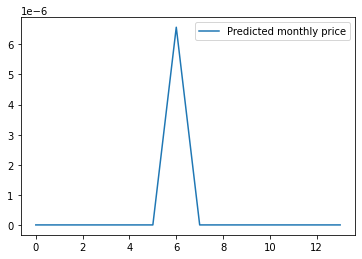

In [580]:
plt.plot(predicted_cases, label='Predicted monthly price')
plt.legend();

In [581]:
plt.figure(figsize=(25,5))
plt.plot(y_3,label='real')
plt.plot(preds_3, label='predict')
plt.xticks(rotation=90)


plt.legend()

NameError: name 'y_3' is not defined

<Figure size 1800x360 with 0 Axes>